# Focus Radargram
This is a different method based off of the reccomended paper

In [1]:
import sys
sys.path.append("../")
from surface import *
from source import *
from model import *
import numpy as np
from time import time as Time

In [2]:
surf = Surface(origin=(0, 0), dims=(101, 101), fs=100)
surf.gen_flat(-10)

# source
ss = []
n = 200
for x in np.linspace(0, 10000, n):
    source = Source(1e-9, 0.5e-6, (x, 5050, 25000))
    source.chirp(9e6, 1e6)
    ss.append(source)

ms = []
st = Time()
for i, s in enumerate(ss):
    print(f"Simulating: {i+1}/{len(ss)} ({round(100*((i+1)/len(ss)), 1)}%)", end="     \r")
    model = Model(surf, s)
    model.set_target((5050, 5050, -200))    # set target location
    model.gen_raypaths(fast=True)    # generate raypaths
    ms.append(model)
print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating: 200/200 (100.0%)     

Total processing time: 3 minutes and 33.12 seconds


In [3]:
# pull index of max transmittance per model
trs = [len(m.raypaths) // 2 for m in ms]

## 2D Focusing

In [4]:
rdrgrm = np.load("../TrackSims/pointtargetssmile.npy")

In [5]:
# start and end of radargram
st = 166.8e-6   # start
en = 175e-6  # end

# time per raypath
pathtimes = np.array([m.raypaths[t].path_time for t, m in zip(trs, ms)])

# delta time of radargram
dt = 1 / (8 * ss[0].f0)

# compute range bin offset
rngbins = (pathtimes - st) // dt
rngbins -= np.min(rngbins)

In [6]:
def focus_pix(rdr, t, T, rngbins, k, dt=dt):

    # sol
    c = 299792458
    
    # compute the range which is within the radargram
    rng = np.arange(len(rngbins)) - (len(rngbins) // 2) + T
    
    # compute the value of the range bins in the image
    rngbins = rngbins[rng >= 0] + t
    
    # crop to the region in the image
    rng = rng[rng >= 0]
    rngbins = rngbins[rng < rdr.shape[1]]
    rng = rng[rng < rdr.shape[1]]
    rng = rng[rngbins < rdr.shape[0]]
    rngbins = rngbins[rngbins < rdr.shape[0]]

    # rangebins to time for exponent calculation
    rngtime = rngbins * dt * c
    exp = np.conjugate(np.exp(2j * k * rngtime))

    return np.sum(rdr[rngbins.astype(int), rng.astype(int)] * exp)

In [7]:
k = (2 * np.pi) / ss[0].lam
focused = np.zeros_like(rdrgrm)
for t in range(rdrgrm.shape[0]):
    print(f"Focusing... {t+1}/{rdrgrm.shape[0]}", end="    \r")
    for T in range(rdrgrm.shape[1]):
        focused[t, T] = focus_pix(rdrgrm, t, T, rngbins, k)

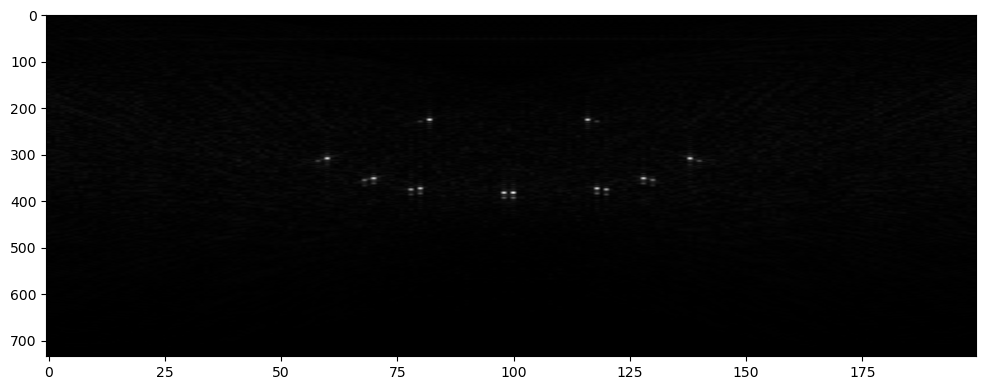

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.abs(focused), cmap="grey", aspect=0.1)
plt.show()